# GraphKT: Graph Neural Networks for Knowledge Tracing

We introduce GraphKT, a graph neural network-based knowledge tracing approach that leverages node embeddings for modeling interdependence between skills. In this Colaboratory, we implement the core components of GraphKT, such as the creation of the skill graph, implementation of the various graph neural networks, and training of the models (including the baseline). The remainder of the helper and utility code is included in the [GitHub repository](https://github.com/abadrinath947/GraphKT) associated with this project.

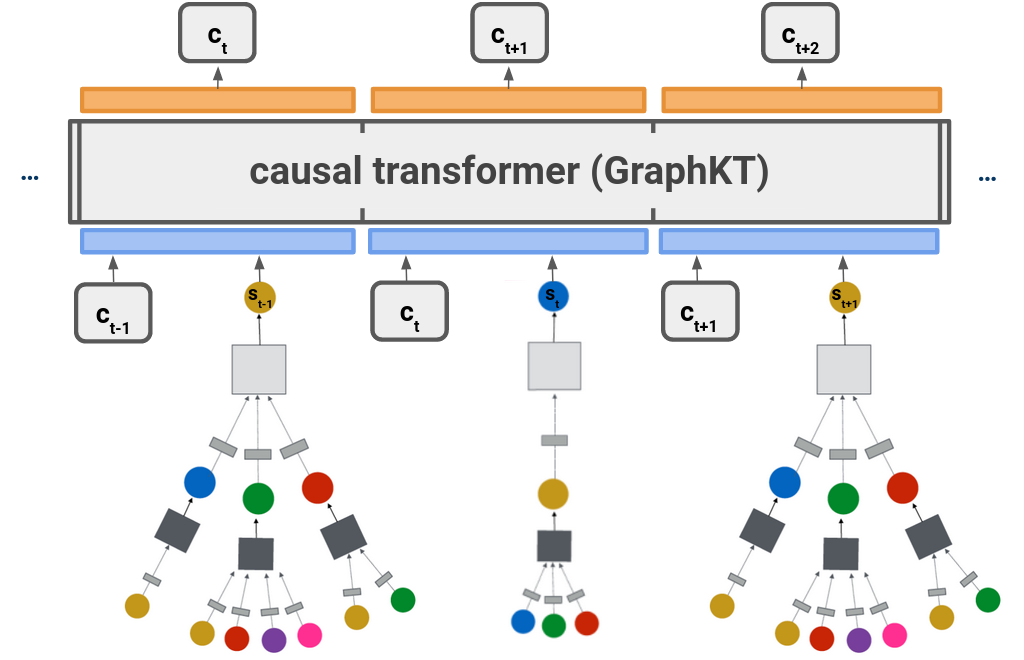

## Setup

The libraries required for this Colab are `torch-geometric`, `torch` and its various accompanying libraries. We install them in the cell below, and clone the GitHub repository for the helper code.

In [ ]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric
%env SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True

!git clone https://github.com/abadrinath947/GraphKT
%cd GraphKT
!mkdir ckpts

We import the relevant libraries for this Colab. These include standard scientific computation libraries such as `numpy` and tabular data processing libraries such as `pandas`, as well as `sklearn`, a basic machine learning library, `torch`, a deep learning library, and `torch_geometric`, a graph-specific extension to `torch`.

The final two imports correspond to the helper code that contains an implementation of a causal transformer based on Andrej Karpathy's [minGPT](https://github.com/karpathy/minGPT) and some pre-processing code.

In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *

import torch.nn as nn
import torch.optim as optim
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

import itertools
from tqdm import tqdm

from transformer import *
from preprocess import *

The dataset used in this Colab for evaluating our KT method is ASSISTments 2009-10 SkillBuilder, containing over 100 skills (e.g., constructing pie charts) and 525,000 total binary correctness responses (with a ~70/30% split of correct and incorrect aggregated across skills). We choose this dataset as it is moderately large and has been used throughout the knowledge tracing literature for comparisons across different methods as a reliable indicator of KT performance.

In [ ]:
# Read KT dataset using Pandas.

data = pd.read_csv('https://github.com/CAHLR/pyBKT-examples/blob/master/data/as.csv?raw=true', encoding = 'latin')
#data = pd.read_csv('../data/as.csv',encoding = 'latin')
# Global hyperparameters for KT model.
num_epochs = 15
batch_size = 8
block_size = 2048

# Graph network hyperparameters.
skill_embd_dim = 128

## Processing Data and Constructing the Skill Graph

The following cells define a variety of functions that split, pre-process, and format the data for training (`train_test_split`/`preprocess_data`/`construct_batches`) and evaluation (`evaluate`). While these are relatively straightforward functions, they are provided for clarity to demonstrate the workflow of our approach.

In [14]:
def train_test_split(data):
    """
    Performs a deterministic train-test split based on the tabular data provided.
    Note that this function needs to be called twice to perform a train-val-test
    split as desired.

    Arguments:
      - data: tabular KT dataset (pd.DataFrame)

    Returns:
      - data_train: training dataset
      - data_val: validation/testing dataset
    """
    np.random.seed(42)
    data = data.set_index(['user_id', 'skill_name'])
    idx = np.random.permutation(data.index.unique())
    train_idx, test_idx = idx[:int(train_split * len(idx))], idx[int(train_split * len(idx)):]
    data_train = data.loc[train_idx].reset_index()
    data_val = data.loc[test_idx].reset_index()
    return data_train, data_val

def preprocess_data(data):
    """
    Pre-process data and pad to the maximum length.
    """
    features = ['skill_id', 'correct']
    # exclude the  groupings
    seqs = data.groupby(['user_id']).apply(lambda x: x[features].values.tolist(),include_groups=False)
    # ensure sequence is not too long
    length = min(max(seqs.str.len()), block_size)
    seqs = seqs.apply(lambda s: s[:length] + (length - min(len(s), length)) * [[-1000] * len(features)])
    return seqs

def construct_batches(raw_data, epoch = 0, val = False):
    """
    Construct batches based on tabular KT data with user_id, skill_id, and
    correctness. Pads to the minimum of the maximum sequence length and the
    block size of the transformer.
    """
    np.random.seed(epoch)
    user_ids = raw_data['user_id'].unique()

    # Loop until one epoch of training.
    for _ in range(len(user_ids) // batch_size):
        user_idx = raw_data['user_id'].sample(batch_size).unique() if not val else user_ids[_ * (batch_size // 2): (_ + 1) * (batch_size // 2)]
        filtered_data = raw_data[raw_data['user_id'].isin(user_idx)].sort_values(['user_id', 'order_id'])
        batch_preprocessed = preprocess_data(filtered_data)
        batch = np.array(batch_preprocessed.to_list())
        # Next token prediction.
        X = torch.tensor(batch[:, :-1, ..., :], requires_grad=True, dtype=torch.float32).cuda()
        y = torch.tensor(batch[:, 1:, ..., [0, 1]], requires_grad=True, dtype=torch.float32).cuda()
        for i in range(X.shape[1] // block_size + 1):
            if X[:, i * block_size: (i + 1) * block_size].shape[1] > 0:
                yield [X[:, i * block_size: (i + 1) * block_size], y[:, i * block_size: (i + 1) * block_size]]

def evaluate(model, batches, baseline = False):
    """
    Evaluates the GraphKT or baseline model on a given set of batches and returns
    the outputted correctness probability predictions.

    Arguments:
      - model: causal transformer (Transformer)
      - batches: evaluation batches (generator from construct_batches function)
      - baseline: whether this is a baseline model (bool)

    Returns:
      - ypred: predicted probabilities (np.ndarray)
      - ytrue: ground truth correctness (np.ndarray)
    """
    ypred, ytrue = [], []
    for X, y in batches:
        # Same code as for training forward pass
        mask = y[..., -1] != -1000
        all_skill_embd = skill_net(torch.arange(110).cuda(), skill_graph.edge_index.cuda(), skill_graph.weight.cuda().float())
        skill_embd = all_skill_embd[torch.where(X[..., 0] == -1000, 0, X[..., 0]).long()]
        ohe = torch.eye(110).cuda()[torch.where(X[..., 0] == -1000, 0, X[..., 0]).long()]
        # Account for baseline and remove node embedding if so.
        if baseline:
            feat = [X, ohe]
        else:
            feat = [X, skill_embd, ohe]
        X = torch.cat(feat, dim = -1)
        corrects = model.forward(X, y[..., 0])[mask]
        y = y[..., -1].unsqueeze(-1)[mask]
        # Squeeze and put into list.
        ypred.append(corrects.ravel().detach().cpu().numpy())
        ytrue.append(y.ravel().detach().cpu().numpy())
    ypred = np.concatenate(ypred)
    ytrue = np.concatenate(ytrue)
    return ypred, ytrue #roc_auc_score(ytrue, ypred)


The following function, `create_skill_graph`, constructs the skill graph based on the rate of ordered co-occurrences, as defined in the blog post.

In [15]:
def create_skill_graph(df):
    # Cache and load if exists.
    if os.path.exists('skill_graph.pickle'):
        print("Using existing skill graph...")
        return pickle.load(open('skill_graph.pickle', 'rb')), pickle.load(open('skill_dict.pickle', 'rb'))

    # Pre-processing steps to remove unwanted responses and group into buckets.
    print("Constructing skill graph...")
    df = df[~df['skill_name'].isna()]
    grouped = df.groupby('user_id')['skill_name'].agg(list)
    uniques = list(df['skill_name'].unique())

    # Count forward co-occurrences in each student sequence.
    skill_cooccurs = {skill_name: np.zeros(df['skill_name'].nunique()) for skill_name in uniques}
    for seq in tqdm(grouped.values):
        cooccur = np.zeros(df['skill_name'].nunique())
        for s in reversed(seq):
            cooccur[uniques.index(s)] += 1
            skill_cooccurs[s] = skill_cooccurs[s] + cooccur

    # Normalize distribution and round to remove noise.
    skill_cooccurs = {k: (v / sum(v)).round(1) for k, v in skill_cooccurs.items()}
    dod = {}
    for i, (skill_name, edges) in enumerate(skill_cooccurs.items()):
        dod[i] = {}
        for j, e in enumerate(edges):
            if e > 0:
                dod[i][j] = {'weight': e}

    # Connect nodes in digraph with forward co-occurrence.
    skill_graph = nx.from_dict_of_dicts(dod)
    skill_dict = dict(zip(uniques, range(len(uniques))))

    # Save and cache graph for future usage.
    pickle.dump(skill_graph, open('skill_graph.pickle', 'wb'))
    pickle.dump(skill_dict, open('skill_dict.pickle', 'wb'))
    return skill_graph, skill_dict

## Graph Neural Network Models

The following section contains a custom implementation of Graph Convolutional Networks (GCN), GraphSAGE, and Graph Attention Networks (GAT) for constructing skill embeddings.

In [16]:
class GCN(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a simple Graph Convolutional Network (GCN) with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GCN'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_weight):
        """
        Runs a forward pass through the GCN with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h0 = self.pre_embs(x) # initial skill embedding
        h1 = self.dropout(self.prelu1(self.conv1(h0, edge_index, edge_weight = edge_weight)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index, edge_weight = edge_weight)))
        h3 = self.prelu3(self.conv3(h2, edge_index, edge_weight = edge_weight))
        return self.out(h3)

In [17]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a GraphSAGE graph neural network with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GraphSAGE'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_weight):
        """
        Runs a forward pass through GraphSAGE with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h0 = self.pre_embs(x) # initial skill embedding
        h1 = self.dropout(self.prelu1(self.conv1(h0, edge_index)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index)))
        h3 = self.prelu3(self.conv3(h2, edge_index))
        return self.out(h3)

In [18]:
class GAT(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a Graph Attention Network (GAT) with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GAT'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = GATConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = GATConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index, edge_weight):
        """
        Runs a forward pass through GAT with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h1 = self.dropout(self.prelu1(self.conv1(self.pre_embs(x), edge_index)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index)))
        h3 = self.prelu3(self.conv3(h2, edge_index))
        return self.out(h3)

## Model Initialization and Training

With all the model classes defined in the above section, we construct the causal transformer and the GNN that power GraphKT in `init_models`. Then, to train the model end-to-end, we define the training loop in `train` over `num_epochs` epoch by optimizing a binary cross-entropy loss.

In [19]:
def init_models(data, skill_embd_dim = skill_embd_dim, graph_net = GAT, baseline = False):
    """
    Pre-process data, generate the skill graph, and initialize the models
    and optimizer.
    """
    # 1. Pre-process data by removing sequences of length 1 and undefined skills.
    # 2. Split data into training and validation set.
    # 3. Generate and load skill graph based on
    data_train, data_val, skill_graph = preprocess(data)
    n_skills = skill_graph.number_of_nodes()

    # Transformer configuration for KT model.
    config = GPTConfig(vocab_size = n_skills, block_size = block_size,
                      n_layer = 2, n_head = 8, n_embd = 128,
                      input_size = 2 + n_skills + skill_embd_dim * (1 - baseline),
                      bkt = False)
    model = GPT(config).cuda()

    # Convert skill_graph to torch_geometric graph and instantiate graph network.
    skill_graph = from_networkx(skill_graph)
    skill_net = graph_net(n_skills, skill_embd_dim).cuda()
    print("Total Parameters:", sum(p.numel() for p in model.parameters()) +
          sum(p.numel() for p in skill_net.parameters()))

    # Optimize all parameters end-to-end.
    optimizer = optim.AdamW(itertools.chain(model.parameters(), skill_net.parameters()), lr = 1e-4)
    return data_train, data_val, skill_graph, model, skill_net, optimizer

The `train` function has several important features:
- the node embeddings are constructed for all skills for each minibatch, and the corresponding node embeddings are chosen for the skills in the problem sequences in the minibatch
- we concatentate the node embeddings with the one-hot encoding for GraphKT and only pass the one-hot encoding for the baseline
- the values with -1000 are masked out since they are padded tokens
- the AUC, accuracy, and RMSE are tracked on the validation set for every epoch, and we checkpoint the model and skill network

In [20]:
def train(model, skill_net, data_train, data_val, num_epochs, baseline = False):
    """
    Train the KT transformer and GNN end-to-end by optimizing the KT binary
    cross-entropy objective.

    Arguments:
      - model (transformer for KT)
      - skill_net (GNN for skill embeddings)
      - data_train (training data)
      - data_val (validation data)
      - num_epochs (number of training epochs)
    """
    for epoch in range(num_epochs):
        # Train model for num_epochs epochs.
        model.train()
        skill_net.train()
        batches_train = construct_batches(data_train, epoch = epoch)
        pbar = tqdm(batches_train)
        losses = []

        for X, y in pbar:
            optimizer.zero_grad()

            # Get node embeddings for all skills from skill_net (GNN).
            all_skill_embd = skill_net(torch.arange(110).cuda(),
                                       skill_graph.edge_index.cuda(),
                                       skill_graph.weight.cuda().float())

            # Select node embeddings corresponding to skill tagged with data.
            skill_embd = all_skill_embd[torch.where(X[..., 0] == -1000, 0, X[..., 0]).long()]
            ohe = torch.eye(110).cuda()[torch.where(X[..., 0] == -1000, 0, X[..., 0]).long()]

            # Concatenate data with skill embedding and one-hot encoding of skill.
            if baseline:
                feat = [X, ohe]
            else:
                feat = [X, skill_embd, ohe]
            output = model(torch.cat(feat, dim = -1), skill_idx = y[..., 0].detach()).ravel()

            # Compute loss and mask padded values.
            mask = (y[..., -1] != -1000).ravel()
            loss = F.binary_cross_entropy(output[mask], y[..., -1:].ravel()[mask])

            # Backpropagate and take a gradient step.
            loss.backward()
            optimizer.step()

            # Report the training loss.
            losses.append(loss.item())
            pbar.set_description(f"Training Loss: {np.mean(losses)}")

        if epoch % 1 == 0:
            # Evaluate model using validation set.
            batches_val = construct_batches(data_val, val = True)
            model.eval()
            skill_net.eval()

            # Construct predictions based on current model and compute error(s).
            ypred, ytrue = evaluate(model, batches_val, baseline = baseline)
            auc = roc_auc_score(ytrue, ypred)
            acc = (ytrue == ypred.round()).mean()
            rmse = np.sqrt(np.mean((ytrue - ypred) ** 2))

            # Report error metrics on validation set and save checkpoint.
            print(f"Epoch {epoch}/{num_epochs} - [VALIDATION AUC: {auc}] - [VALIDATION ACC: {acc}] - [VALIDATION RMSE: {rmse}]")
            torch.save(model.state_dict(), f"ckpts/model-{skill_net.tag}-{epoch}-{auc}-{acc}-{rmse}.pth")
            if not baseline:
                torch.save(skill_net.state_dict(), f"ckpts/skill_net-{skill_net.tag}-{epoch}-{auc}-{acc}-{rmse}.pth")

def init_graphkt(graph_net):
    data_train, data_test = train_test_split(data)
    #torch.cuda.empty_cache()
    # Initialize and train models with GCN, GraphSAGE and GAT.
    data_train, data_val, skill_graph, model, skill_net, optimizer = init_models(data_train, graph_net = graph_net)
    print(f"Training {skill_net.tag} model!")
    return data_train, data_val, skill_graph, model, skill_net, optimizer

The following trains GraphKT using GCN for the skill network.

In [ ]:
data_train, data_val, skill_graph, model, skill_net, optimizer = init_graphkt(GCN)
train(model, skill_net, data_train, data_val, num_epochs)

The following trains GraphKT using GraphSAGE for the skill network.

In [ ]:
data_train, data_val, skill_graph, model, skill_net, optimizer = init_graphkt(GraphSAGE)
train(model, skill_net, data_train, data_val, num_epochs)

The following trains GraphKT using GAT for the skill network.

In [ ]:
data_train, data_val, skill_graph, model, skill_net, optimizer = init_graphkt(GAT)
train(model, skill_net, data_train, data_val, num_epochs)

The following trains the Self-Attentive Knowledge Tracing baseline without any graphs.

In [ ]:
data_train, data_test = train_test_split(data)
torch.cuda.empty_cache()
data_train, data_val, skill_graph, model, skill_net, optimizer = init_models(data_train, graph_net = GCN, baseline = True)
train(model, skill_net, data_train, data_val, num_epochs, baseline = True)

## Evaluation

To evaluate on the test set in a robust fashion, we construct 100 random samples of the unseen test set (i.e., similar to bootstrapping) and evaluate all the GraphKT models and the baseline on these samples to construct confidence intervals.

To construct the 95% confidence interval, we use the t-distribution from `scipy`, where $k = 100$.

In [ ]:
data_train, data_test = train_test_split(data)

def bootstrap(data, seed = 0, size = data.shape[0] // 10):
    """
    Bootstrapping function for evaluation of GraphKT based on random samples
    of the test data.
    """
    # Seed the bootstrap to make the function deterministic.
    np.random.seed(seed)
    data = data.set_index(['user_id', 'skill_name'])
    idx = np.random.permutation(data.index.unique())[:size]
    return data.loc[idx].reset_index()

aucs = {'gcn': [], 'baseline': [], 'gat': [], 'graphsage': []}
accs = {'gcn': [], 'baseline': [], 'gat': [], 'graphsage': []}
rmses = {'gcn': [], 'baseline': [], 'gat': [], 'graphsage': []}

for i in range(100):
    data_test = bootstrap(data_test, seed = i)
    skill_dict = pickle.load(open('skill_dict.pickle', 'rb'))

    # Pre-processing...
    data_test = data_test.groupby('user_id').filter(lambda x: (~x['skill_name'].isna()).all())
    data_test['skill_id'] = data_test['skill_name'].apply(lambda s: skill_dict[s])

    # Test the GCN.
    _, _, skill_graph, model, skill_net, optimizer = init_models(data_train, graph_net = GCN)
    model.load_state_dict(torch.load('model-GCN-14-0.825194627437027-0.784551629854317-0.3887104392051697.pth'))
    skill_net.load_state_dict(torch.load('skill_net-GCN-14-0.825194627437027-0.784551629854317-0.3887104392051697.pth'))
    model.eval(); skill_net.eval()
    batches_test = construct_batches(data_test, val = True)
    ypred, ytrue = evaluate(model, batches_test)
    auc = roc_auc_score(ytrue, ypred)
    acc = (ytrue == ypred.round()).mean()
    rmse = np.sqrt(np.mean((ytrue - ypred) ** 2))
    aucs['gcn'].append(auc)
    accs['gcn'].append(acc)
    rmses['gcn'].append(rmse)

    # Test the baseline (SAKT).
    _, _, skill_graph, model, skill_net, optimizer = init_models(data_train, graph_net = GCN, baseline = True)
    model.eval(); skill_net.eval()
    model.load_state_dict(torch.load('model-GCN-14-0.8144997102601215-0.7734011193232794-0.39574989676475525.pth'))
    batches_test = construct_batches(data_test, val = True)
    ypred, ytrue = evaluate(model, batches_test, baseline = True)
    auc = roc_auc_score(ytrue, ypred)
    acc = (ytrue == ypred.round()).mean()
    rmse = np.sqrt(np.mean((ytrue - ypred) ** 2))
    aucs['baseline'].append(auc)
    accs['baseline'].append(acc)
    rmses['baseline'].append(rmse)

    # Test the GAT.
    _, _, skill_graph, model, skill_net, optimizer = init_models(data_train, graph_net = GAT)
    model.load_state_dict(torch.load('model-GAT-8-0.825283662217596-0.7717135899517238-0.3911440372467041.pth'))
    skill_net.load_state_dict(torch.load('skill_net-GAT-8-0.825283662217596-0.7717135899517238-0.3911440372467041.pth'))
    model.eval(); skill_net.eval()
    batches_test = construct_batches(data_test, val = True)
    ypred, ytrue = evaluate(model, batches_test)
    auc = roc_auc_score(ytrue, ypred)
    acc = (ytrue == ypred.round()).mean()
    rmse = np.sqrt(np.mean((ytrue - ypred) ** 2))
    aucs['gat'].append(auc)
    accs['gat'].append(acc)
    rmses['gat'].append(rmse)

    # Test the GraphSAGE model.
    _, data_val, skill_graph, model, skill_net, optimizer = init_models(data_train, graph_net = GraphSAGE)
    model.load_state_dict(torch.load('model-GraphSAGE-9-0.8237620323541279-0.77030375528688-0.39144018292427063.pth'))
    skill_net.load_state_dict(torch.load('skill_net-GraphSAGE-9-0.8237620323541279-0.77030375528688-0.39144018292427063.pth'))
    model.eval(); skill_net.eval()
    batches_test = construct_batches(data_test, val = True)
    ypred, ytrue = evaluate(model, batches_test)
    auc = roc_auc_score(ytrue, ypred)
    acc = (ytrue == ypred.round()).mean()
    rmse = np.sqrt(np.mean((ytrue - ypred) ** 2))
    aucs['graphsage'].append(auc)
    accs['graphsage'].append(acc)
    rmses['graphsage'].append(rmse)

The following function defines a standard confidence interval for all our methods based on the evaluation in the previous cell.

In [ ]:
from scipy.stats import t

def conf_int(d):
    for method in d:
        interval = t.interval(0.95, 100, loc = np.mean(d[method]), scale = np.std(d[method]))
        mid = sum(interval) / 2
        print(f'{method}: {mid} +- {interval[1] - mid}')

We generate the 95% confidence interval for computing the AUC on the test set.

In [ ]:
conf_int(aucs)

We generate the 95% confidence interval for computing the accuracy on the test set.

In [ ]:
conf_int(accs)

We generate the 95% confidence interval for computing the RMSE on the test set.

In [ ]:
conf_int(rmses)